# Set up

Define work location :

In [5]:
# Define work location
work_loc = 'local'  # colab (google) or local (pc)

Mount Google Drive :

In [6]:
project_path = "My Drive/OPENCLASSROOMS/Projets DATA/6. Classification biens consommation"

if (work_loc == 'colab'):
    # Mount Drive folder
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Drive path
    work_path = "/content/drive/"

elif (work_loc == 'local'):
    # Local drive path
    work_path = "/Users/victor/Library/CloudStorage/GoogleDrive-vicozer@gmail.com/"

else:
    raise ValueError("Choose between 'colab' or 'local' work!")

Python librairies install :

In [7]:
if work_loc == 'colab':
  %pip install fasttext
  %pip install transformers
  %pip install tensorflow

Python librairies imports :

In [8]:
import os
import time
import copy
import numpy as np
import pandas as pd
import re
import csv

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from string import punctuation

import fasttext

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, f1_score, accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets, transforms
from torchvision.models import resnet50
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

import cv2
import glob
from pathlib import Path
import shutil

import missingno as msno

import warnings

# Remove warning
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

%matplotlib inline
sns.set_theme(palette="Set2")

Load pycodestyle (PEP8) :

In [9]:
if (work_loc == 'local'):
    # Pycodestyle (PEP8)
    %load_ext pycodestyle_magic
    %pycodestyle_on --max_line_length 125  # GitHub limit

Load data :

In [10]:
# Load data
clean_df = pd.read_csv("clean_df.csv")
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

# Get images
images = clean_df['images'].to_list()
train_images = train_df['images'].to_list()
test_images = test_df['images'].to_list()

# Get labels
labels = clean_df['labels'].to_list()
train_labels = train_df['labels'].to_list()
test_labels= test_df['labels'].to_list()
labels_encoded = clean_df['labels_encoded'].to_list()
train_labels_encoded = train_df['labels_encoded'].to_list()
test_labels_encoded = test_df['labels_encoded'].to_list()

print(images[:5])
print(labels[:5])

14:12: E225 missing whitespace around operator


['55b85ea15a1536d46b7190ad6fff8ce7.jpg', '7b72c92c2f6c40268628ec5f14c6d590.jpg', '64d5d4a258243731dc7bbb1eef49ad74.jpg', 'd4684dcdc759dd9cdf41504698d737d8.jpg', '6325b6870c54cd47be6ebfbffa620ec7.jpg']
['Home Furnishing Others', 'Baby Care Others', 'Baby Care Others', 'Bed Linen', 'Bed Linen']


# Functions

## Image functions

In [11]:
# Copy image in new folder (directory)
def copy_images_in_new_folder(images_names, images_labels, folder_path, new_folder):

    # Create folder if not existing
    if not Path(folder_path + new_folder).exists():
        os.makedirs(folder_path + new_folder)

    for image_name, image_label in zip(images_names, images_labels):
        image_path = folder_path + image_name

        # Create label folder if not existing
        label_path = os.path.join(folder_path, new_folder, image_label)

        if not Path(label_path).exists():
            os.makedirs(label_path)

        # Copy image
        image_destination = os.path.join(label_path, image_name)
        shutil.copy(image_path, image_destination)

In [13]:
# Display an image
def display_image_cv(image_cv, title="Image", figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.title(title)
    plt.imshow((image_cv * 255).astype(np.uint8))
    plt.tight_layout()
    plt.show()

# Training and testing sets

I copy the images in two folders (train and test).

In [15]:
# Copy train images in train folder
copy_images_in_new_folder(train_images, train_labels,
                          work_path + project_path + "/Flipkart/Images/",
                          "TRAIN")

# Copy test images in test folder
copy_images_in_new_folder(test_images, test_labels,
                          work_path + project_path + "/Flipkart/Images/",
                          "TEST")

# CNN : ResNet50

## Create the datasets

In [16]:
# Define ImageNet mean and standard deviation and image size
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224

I load the images with pytorch and create training and testing sets.

In [17]:
# Data transformation (augmentation pipeline)
data_transforms = {
   'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
   ]),
   'TEST': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
   ]),
}

# Images datasets
image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(work_path + project_path + "/Flipkart/Images/", x),
       transform=data_transforms[x]
   )
   for x in ['TRAIN', 'TEST']
}

# Dataloaders
dataloaders = {
   x: DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['TRAIN', 'TEST']
}

# Device
torch_device = torch.device("cpu")

dataset_sizes = {x: len(image_datasets[x]) for x in ['TRAIN', 'TEST']}
print(dataset_sizes)

# Get images labels
images_classes = image_datasets['TRAIN'].classes

{'TRAIN': 735, 'TEST': 315}


Let's display some of the images from the training set.

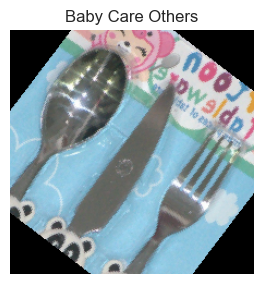

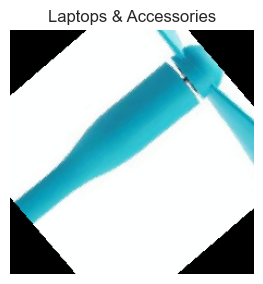

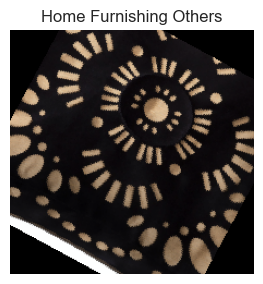

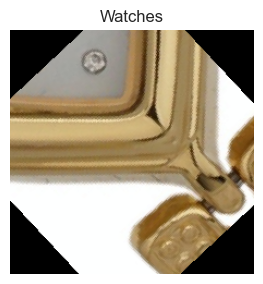

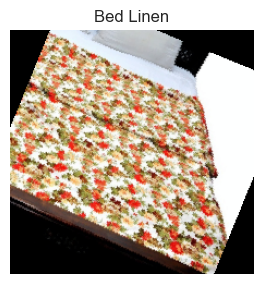

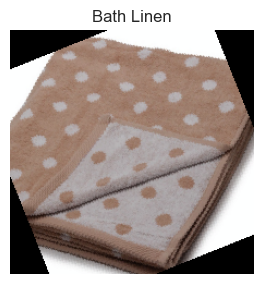

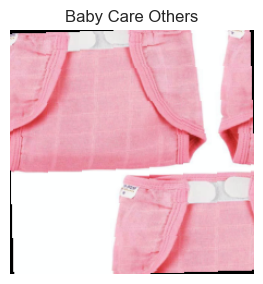

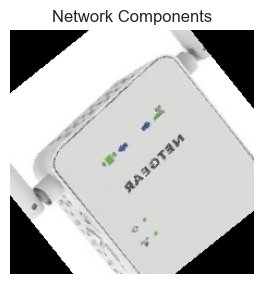

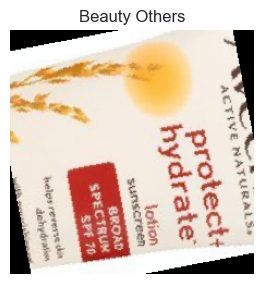

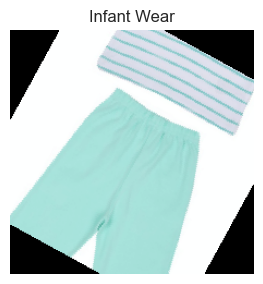

In [18]:
# Get images and labels
imgs, imgs_labels = next(iter(dataloaders['TRAIN']))

# Display first 10 images
for i in range(10):
    # Prepare image cv
    image_cv = imgs[i].numpy().transpose((1, 2, 0))
    image_cv = STD * image_cv + MEAN

    # Display image
    display_image_cv(image_cv, title=images_classes[imgs_labels[i]])

## Train the CNN model

I load the **ResNet50** model.

In [21]:
# Unverified context to avoid ssl failed
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load the resnet model
cnn_model = resnet50(weights="ResNet50_Weights.DEFAULT")

# Freeze the layers
for param in cnn_model.parameters():
    param.requires_grad = False

I fintune the model.

In [22]:
n_features = cnn_model.fc.in_features
cnn_model.fc = torch.nn.Linear(n_features, len(images_classes))
cnn_model = cnn_model.to(torch_device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

I train the ResNet50 model.

In [23]:
# Train CNN model
def cnn_train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['TRAIN', 'TEST']:
            if phase == 'TRAIN':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(torch_device)
                labels = labels.to(torch_device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'TRAIN'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'TRAIN':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'TRAIN':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'TEST' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
# Train model
cnn_model = cnn_train_model(cnn_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
TRAIN Loss: 2.8817 Acc: 0.1619


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.7604 Acc: 0.2667

Epoch 1/24
----------
TRAIN Loss: 2.6928 Acc: 0.2313


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.5663 Acc: 0.2889

Epoch 2/24
----------
TRAIN Loss: 2.5427 Acc: 0.2898


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.4144 Acc: 0.3651

Epoch 3/24
----------
TRAIN Loss: 2.4122 Acc: 0.3279


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.2920 Acc: 0.4286

Epoch 4/24
----------
TRAIN Loss: 2.2975 Acc: 0.4204


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.1928 Acc: 0.4571

Epoch 5/24
----------
TRAIN Loss: 2.2431 Acc: 0.4367


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.1180 Acc: 0.4952

Epoch 6/24
----------
TRAIN Loss: 2.1602 Acc: 0.4830


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.0360 Acc: 0.5365

Epoch 7/24
----------
TRAIN Loss: 2.1226 Acc: 0.4898


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.0361 Acc: 0.5365

Epoch 8/24
----------
TRAIN Loss: 2.0904 Acc: 0.5007


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.0275 Acc: 0.5365

Epoch 9/24
----------
TRAIN Loss: 2.1029 Acc: 0.4816


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 2.0119 Acc: 0.5365

Epoch 10/24
----------
TRAIN Loss: 2.1067 Acc: 0.4966


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9959 Acc: 0.5365

Epoch 11/24
----------
TRAIN Loss: 2.0562 Acc: 0.4952


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9953 Acc: 0.5429

Epoch 12/24
----------
TRAIN Loss: 2.0943 Acc: 0.4871


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9907 Acc: 0.5460

Epoch 13/24
----------
TRAIN Loss: 2.0713 Acc: 0.4830


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9973 Acc: 0.5524

Epoch 14/24
----------
TRAIN Loss: 2.1073 Acc: 0.4830


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9920 Acc: 0.5524

Epoch 15/24
----------
TRAIN Loss: 2.0665 Acc: 0.4939


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9832 Acc: 0.5556

Epoch 16/24
----------
TRAIN Loss: 2.0389 Acc: 0.5129


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9866 Acc: 0.5429

Epoch 17/24
----------
TRAIN Loss: 2.0604 Acc: 0.4925


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9975 Acc: 0.5492

Epoch 18/24
----------
TRAIN Loss: 2.0637 Acc: 0.4857


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9820 Acc: 0.5492

Epoch 19/24
----------
TRAIN Loss: 2.0424 Acc: 0.5007


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9860 Acc: 0.5492

Epoch 20/24
----------
TRAIN Loss: 2.0595 Acc: 0.5116


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9803 Acc: 0.5556

Epoch 21/24
----------
TRAIN Loss: 2.0678 Acc: 0.5293


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9810 Acc: 0.5556

Epoch 22/24
----------
TRAIN Loss: 2.0658 Acc: 0.4980


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9766 Acc: 0.5587

Epoch 23/24
----------
TRAIN Loss: 2.0600 Acc: 0.5020


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9827 Acc: 0.5492

Epoch 24/24
----------
TRAIN Loss: 2.0454 Acc: 0.4871


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


TEST Loss: 1.9960 Acc: 0.5492

Training complete in 72m 4s
Best val Acc: 0.558730


I evaluate the trained model.

In [25]:
# Evaluate the model
cnn_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

I display some predictions.

In [30]:
def cnn_display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['TRAIN']):
            inputs = inputs.to(torch_device)
            labels = labels.to(torch_device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = STD * img + MEAN
                display_image_cv(img, title='predicted: {} truth: {}'
                                 .format(images_classes[preds[j]], images_classes[labels[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

<Figure size 640x480 with 0 Axes>

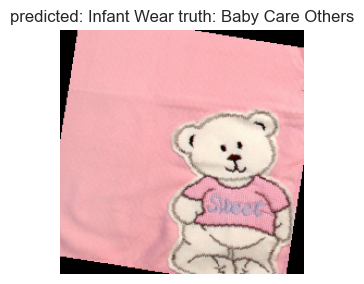

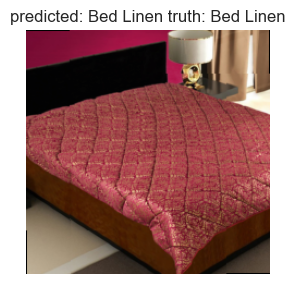

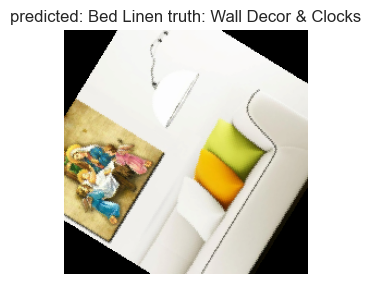

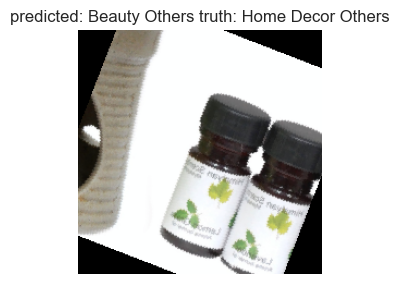

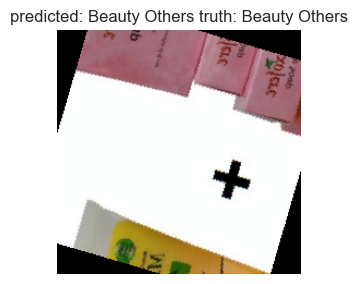

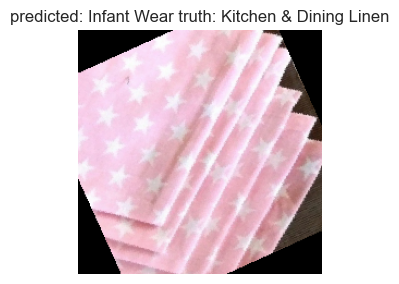

In [27]:
cnn_display_predictions(cnn_model)

I save the trained model.

In [28]:
# Define output_directory
output_dir = './cnn_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save trained model
torch.save(cnn_model.state_dict(), "cnn_save/cnn_model.pth")

Saving model to ./cnn_save/
